**deepSISOnoCSI**<br>
by $\text{Rishabh Pomaje}$
- Autoencoder based SISO system with no **CSI** 
- Objectives : 
    - To learn a (4, 7) system under the following conditions :
        1. Flat-fading, Fast-fading  
        2. Rayleigh Channel with AWGN 
        3. Channel Model : $y_i = h_i x_i + w_i$
            - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

In [5]:
# Importing the dependencies 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg' # Comment this for faster plot rendering 
print(tf.__version__)

2.16.1


### Without Coding

- System Parameters/ Definitions 

In [2]:
k = 1                       # Number of bits required
M = 2                       # Size of alphabet
n = 2                       # Size of coded vector 
R = k / n                   # Information/ Communication rate 

- Generation of training data

In [3]:
training_set_size = 10 ** 6 
SNR_TRAIN = float(input('Enter training SNR'))
# Random indices 
sample_indices = np.random.randint(0, M, training_set_size)

# Corresponding 1-hot vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'One Hot encoded vectors :{x_train}')
print(f'Input Shape :{np.shape(x_train)}')
# Since we are reproducing the input at the output :
y_train = x_train 

# Generate random fading tap samples for training
fading_mean = 0 
fading_std = np.sqrt(0.5)
fading_taps_I = np.random.normal(fading_mean, fading_std, (training_set_size, n)) 
fading_taps_Q = np.random.normal(fading_mean, fading_std, (training_set_size, n))

One Hot encoded vectors :[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Input Shape :(1000000, 2)


- Creating the Autoencoder

In [4]:
# Encoder(transmitter) part 
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_02)

fading_layer_real = tf.keras.Input(shape=(n, ), name='fading_real_part')
fading_layer_imag = tf.keras.Input(shape=(n,), name='fading_taps_imag')
# Rayleigh Fading 
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Gaussian noise 
# SNR_TRAIN = 10
SNR_lin = 10 ** (SNR_TRAIN / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * SNR_lin)), name='AWGN_channel_I')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * SNR_lin)), name='AWGN_channel_Q')(rx_signal_imag)

# Decoder(Receiver) 
# Concatenating the real and imag noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag])
dec_layer_01 = tf.keras.layers.Dense(8*M, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(4*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_layer_04 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_04')(dec_layer_03)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_04)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 2)         │          6 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_02   │ (None, 2)         │          6 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 2)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_real_part    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 2)         │          0 │ Power_Constraint… │
│                     │                   │            │ fading_real_part… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 2)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 2)         │          0 │ multiply[0][0]    │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 2)         │          0 │ multiply_1[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4)         │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 16)        │         80 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 8)         │        136 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 4)         │         36 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_04   │ (None, 2)         │         10 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 2)         │          6 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280 (1.09 KB)

 Trainable params: 280 (1.09 KB)

 Non-trainable params: 0 (0.00 B)

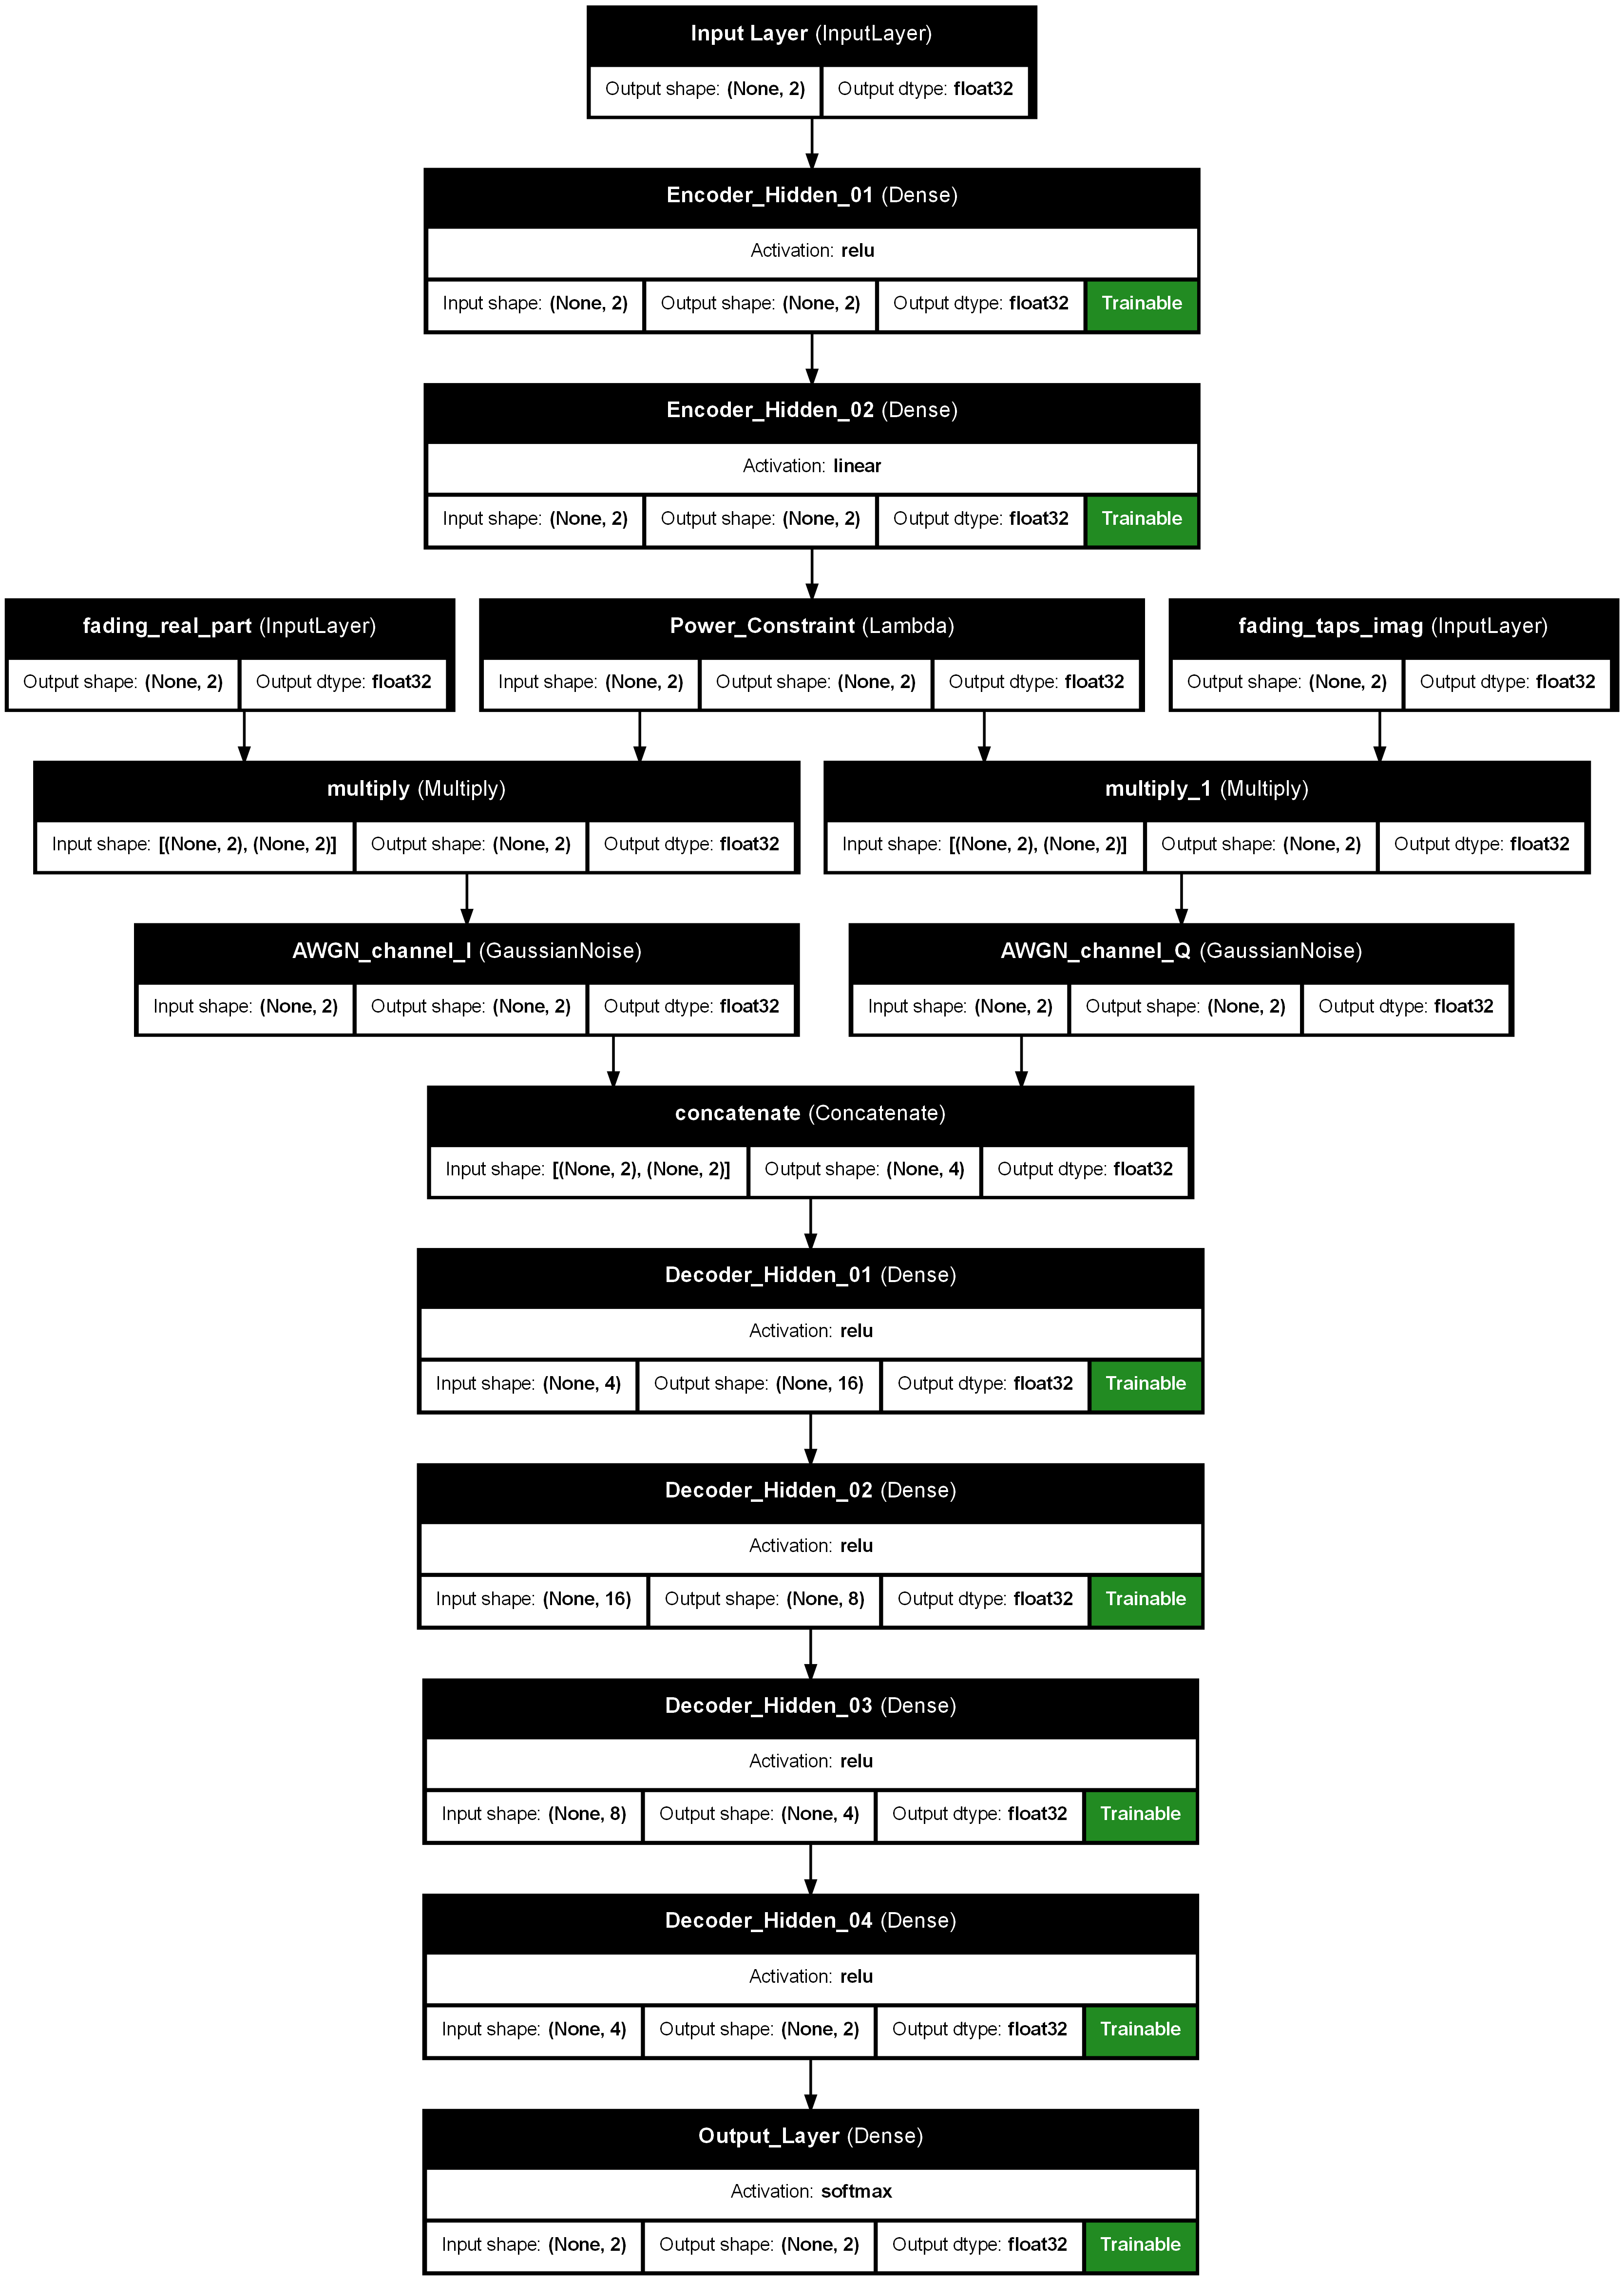

In [6]:
# To view the block diagram of the autoencoder
tf.keras.utils.plot_model(
    autoencoder,
    to_file='images/deepSISOnoCSI_noCoding.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [ ]:
# Fitting the model by using the training set :
autoencoder.fit([x_train, fading_taps_I, fading_taps_Q], y_train, batch_size=1000, epochs=100)

- Testing the above encoder at various SNRs

Generation of validation data 

In [ ]:
testing_set_size = 10 ** 6 
y_test = np.random.randint(0, M, testing_set_size)
x_test = np.zeros((testing_set_size, M))  
x_test[np.arange(testing_set_size), y_test] = 1  # One-hot encoding
print(x_test)

In [ ]:
# Abstracting out the encoder model :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Codeword Received at the receiver :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-6]([rx_noisy_signal_I, rx_noisy_signal_Q])
decoder_output = autoencoder.layers[-5](decoder_output)
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the decoder model :
decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q], decoder_output)

- Validation Routine

In [ ]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of total noise variance accordingly :
noise_var = 1 / (2 * SNR_lin) 
encoded_samples = encoder_model.predict(x_test)

In [ ]:
np.shape(encoded_samples)

In [ ]:
with open("results/noCSImapping.txt", mode='w') as file_id:
    for i in range(50):
        if i == 0 :
            file_id.write(f'encoded_samples = {encoded_samples[i]},\n')
        else:
            file_id.write(f'{encoded_samples[i]},\n')

In [ ]:
# Visualizing the lernt encoding : 
fig, axes = plt.subplots()
for i in range(10):
    axes.scatter(encoded_samples[i][0], encoded_samples[i][1], color='orangered', marker="D", s=2**6)
# Move left y-axis and bottom x-axis to centre, passing through (0,0)
axes.spines['left'].set_position('center')
axes.spines['bottom'].set_position('center')

# Eliminate upper and right axes
axes.spines['right'].set_color('none')
axes.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')
axes.grid()
axes.set_title(f'Learnt Encoding in no CSI scenario - {SNR_TRAIN}')
fig.savefig(f'plots/noCSImapping_{SNR_TRAIN}.svg', transparent=True)

- We are restraining to using only BPSK mapping.

We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

In [ ]:
BLER_learned_uncoded = []
for noise in noise_var:
    # Encoding
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (testing_set_size, n)) + 1j * np.random.normal(fading_mean, fading_std, (testing_set_size, n))
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n)) + 1j * np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal)])
    # Analysis
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_uncoded.append(np.sum(estimated_vectors != y_test) / testing_set_size)

### With Coding 

- System Parameters/ Definitions 

In [6]:
k = 4                       # Number of bits required
n = 7                       # Size of coded vector 
M = 2 ** k                  # Size of alphabet
R = k / n                   # Information/ Communication rate 

- Generation of training data

In [7]:
training_set_size = 10 ** 6  # Equivalent to k million bits

# Random indices 
sample_indices = np.random.randint(0, M, training_set_size)

# Random 1-hot encoded vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'One Hot encoded vectors :{x_train}')
print(f'Input Shape :{np.shape(x_train)}')
# Since we are reproducing the input at the output :
y_train = x_train # Setting the labels as the inputs 

# Generate random fading tap samples for training
fading_mean = 0 
fading_std = np.sqrt(0.5)
# # Rayleigh Fading :
fading_taps_I = np.random.normal(fading_mean, fading_std, (training_set_size, n)) 
fading_taps_Q = np.random.normal(fading_mean, fading_std, (training_set_size, n))

One Hot encoded vectors :[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Input Shape :(1000000, 16)


- Creating the Autoencoder

In [11]:
# Description of the encoder(transmitter) part :
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
enc_layer_03 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_03")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_03)

# Describing the AWGN Channel with Rayleigh fading :
fading_layer_real = tf.keras.Input(shape=(n, ), name='fading_real_part')
fading_layer_imag = tf.keras.Input(shape=(n, ), name='fading_taps_imag')
# y = fx + w  model(flat + fast fading):
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Adding the Gaussian noise :
SNR_TRAIN = float(input('Enter training SNR'))
SNR_lin = 10 ** (SNR_TRAIN / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_I')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_Q')(rx_signal_imag)

# Description of the decoder part :
# Concatenating the real and imag noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag])
dec_layer_01 = tf.keras.layers.Dense(2*n, activation='linear', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(1*M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_03)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 16)        │        272 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_03   │ (None, 7)         │        119 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 7)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_real_part    │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 7)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_real_part… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 7)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 7)         │          0 │ multiply_2[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 7)         │          0 │ multiply_3[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 14)        │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 14)        │        210 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 32)        │        480 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 16)        │        528 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 16)        │        272 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

- Training the autoencoder

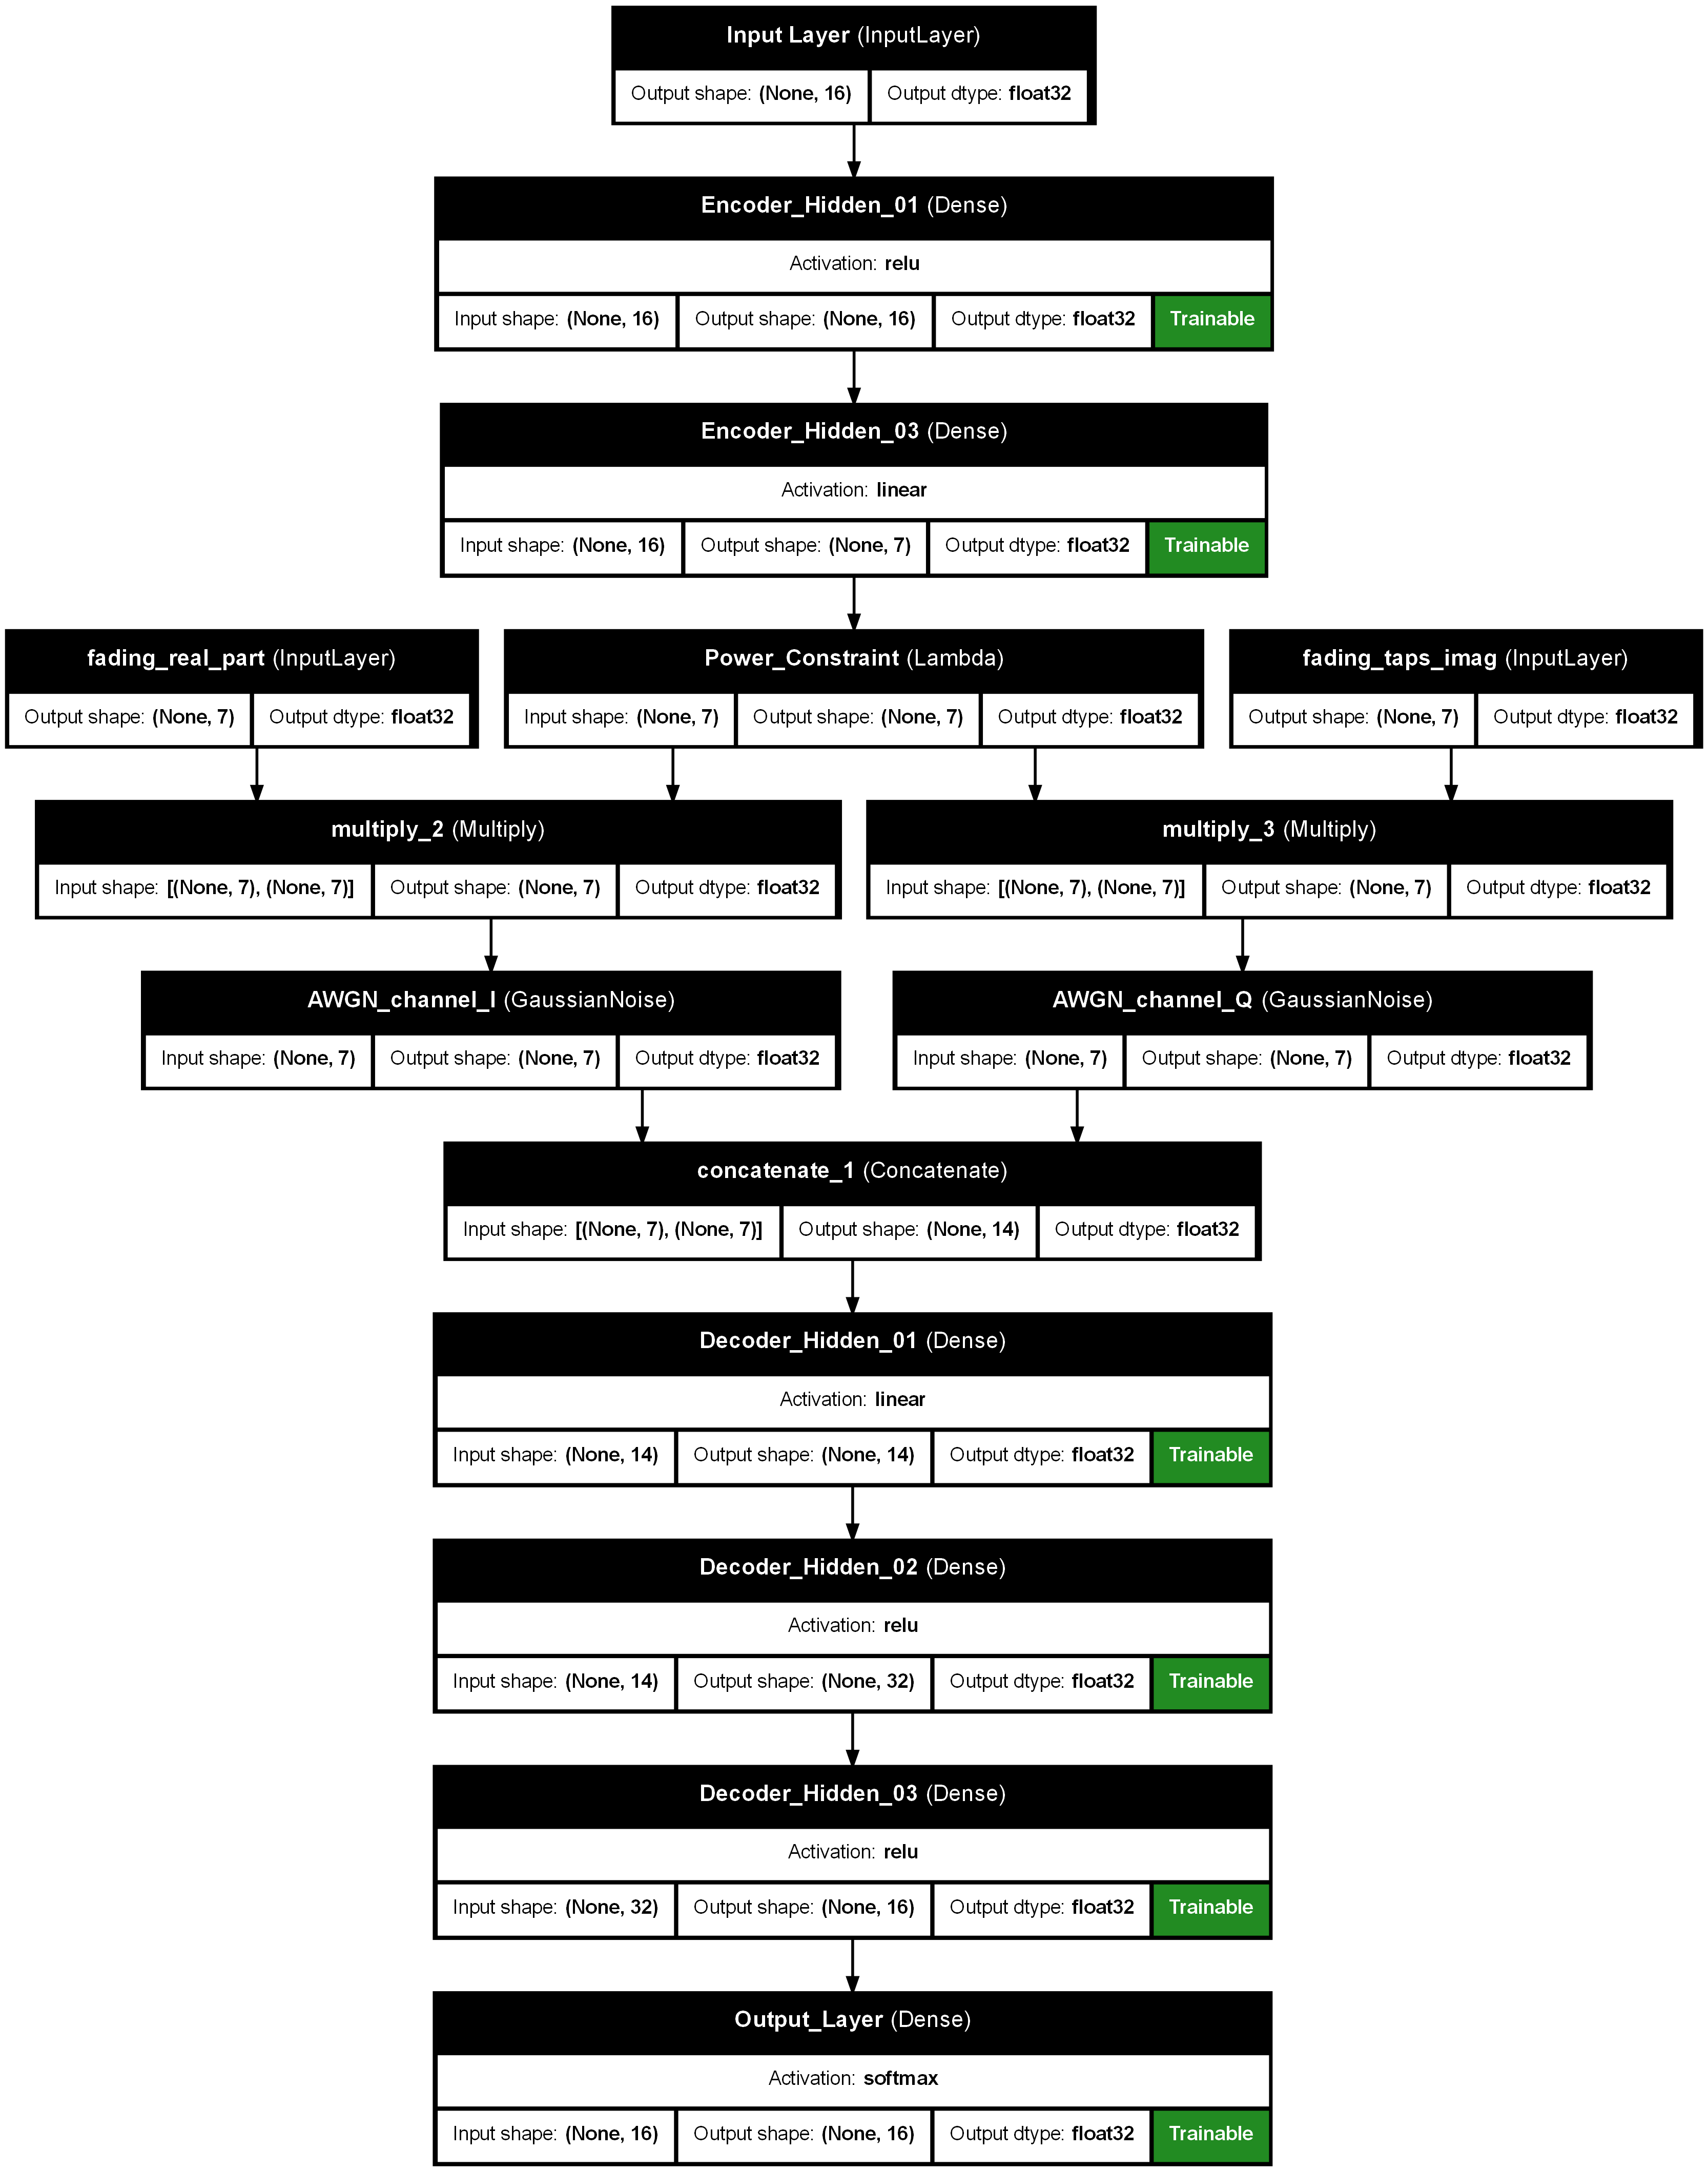

In [12]:
# To view the block diagram of the autoencoder
tf.keras.utils.plot_model(
    autoencoder,
    to_file='images/deepSISOnoCSI_Coding.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [13]:
autoencoder.fit([x_train, fading_taps_I, fading_taps_Q], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2236 - loss: 2.0802
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3467 - loss: 1.3992
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3521 - loss: 1.3813
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3529 - loss: 1.3741
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3533 - loss: 1.3712
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3543 - loss: 1.3711
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3537 - loss: 1.3694
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3540 - loss: 1.3687
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3540 - loss: 1.3672
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3537 - loss: 1.3650
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3544 - loss: 1.3651
Epoch 12/100
1000/1

KeyboardInterrupt: 

- Testing the above encoder at various SNRs

Generation of testing/ validation data 

In [ ]:
testing_set_size = 10 ** 6
y_test = np.random.randint(0, M, testing_set_size)
x_test = np.zeros((testing_set_size, M))  
x_test[np.arange(testing_set_size), y_test] = 1  # One-hot encoding
print(x_test)

- Abstracting the encoder and decoder for use from the trained autoencoder

In [ ]:
# Abstracting out the encoder model :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Codeword Received at the receiver :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-5]([rx_noisy_signal_I, rx_noisy_signal_Q])
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the decoder model :
decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q], decoder_output)

- Validation Routine

In [ ]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of total noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 
print(encoder_model.predict(x_test[:5]))

In [ ]:
BLER_learned_coded = []
for noise in noise_var:
    # Encoding
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (testing_set_size, n)) + 1j * np.random.normal(fading_mean, fading_std, (testing_set_size, n))
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n)) + 1j * np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal)])
    # Analysis
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_coded.append(np.sum(estimated_vectors != y_test) / testing_set_size)

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family" : 'serif',
    "font.size": 12
})
# Visualizing the results :
# Comparable BLERs :
BLER_uncoded_ortho = [0.768583, 0.739292, 0.705981, 0.669923, 0.630311, 0.587876, 0.544343, 0.500471, 0.455975, 0.410657, 0.367179, 0.327169, 0.287849, 0.252541, 0.220754, 0.191105, 0.165363, 0.142107, 0.121575, 0.104422, 0.08893, 0.075213, 0.064247, 0.054353, 0.045771, 0.038804, 0.032647, 0.027541, 0.023478, 0.019544]
BLER_coded_ortho_hard = [0.795571, 0.765834, 0.731717, 0.692848, 0.648438, 0.599435, 0.545317, 0.489533, 0.432764, 0.375165, 0.320971, 0.267871, 0.221556, 0.178709, 0.142342, 0.111386, 0.086019, 0.066173, 0.049922, 0.037385, 0.027819, 0.020596, 0.014932, 0.010915, 0.007867, 0.005756, 0.004155, 0.00294, 0.002141, 0.001472]
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_learned_uncoded, label='Learned Uncoded System', color='coral', marker='s', ls=" ")
axes.semilogy(SNR_dB, BLER_learned_coded, label='Learned Coded System', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_ortho, label='Uncoded BPSK', color='black')
axes.semilogy(SNR_dB, BLER_coded_ortho_hard, label='Hamming (7, 4) Hard', color='blue', ls="-.")
axes.set_xlabel(f'SNR [in dB]')
axes.set_ylabel(r'$BLER$')
axes.set_xlim(-3, 21)
axes.set_ylim(10**-4, 10**0)
axes.set_title(f'SISO - No CSI')
axes.legend()
axes.grid()

In [ ]:
# Saving the results for future reference :
# Plot(s) :
fig.savefig(f'plots/deepSISOnoCSI_{SNR_TRAIN}.svg', transparent=True)
# BLERs :
with open(f'results/deepSISOnoCSI_{SNR_TRAIN}.txt', mode='w') as file_id:
    file_id.write(f'BLER_learned_coded = {BLER_learned_coded}\n')
    file_id.write(f'BLER_learned_uncoded = {BLER_learned_uncoded}\n')
    file_id.write(f'BLER_uncoded_ortho = {BLER_uncoded_ortho}\n')
    file_id.write(f'BLER_coded_ortho_hard = {BLER_coded_ortho_hard}')